In [1]:
from google.colab import files
import pandas as pd

# Upload files
uploaded = files.upload()

# After upload, read the files
df = pd.read_csv("combined_multilingual_mmlu.csv")

Saving combined_multilingual_mmlu.csv to combined_multilingual_mmlu.csv


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from collections import Counter


In [3]:
# ---------- quick helpers ----------
def top_counts(series, k=20):
    return series.fillna("∅").astype(str).value_counts().head(k)

def text_len(s):
    return s.fillna("").astype(str).str.len()

def safe_title(t):  # avoid overflowing figure titles
    return str(t)[:80]


In [9]:
COLS = {
    "question": "Question",
    "A": "A",
    "B": "B",
    "C": "C",
    "D": "D",
    "answer": "Answer",
    "subject": "Subject",
    "language": "Language",
    "source_file": "Source_File",
    "combined_date": "Combined_Date",
    "total_lang": "Total_Languages",
    "processed_at": "processed_at",
}

# --- Column existence check ---
missing = [v for v in COLS.values() if v not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

# processed_at → datetime
df[COLS["processed_at"]] = pd.to_datetime(df[COLS["processed_at"]], errors="coerce")

# Combined_Date → datetime (since it's a date column, not numeric)
df[COLS["combined_date"]] = pd.to_datetime(df[COLS["combined_date"]], errors="coerce")

# Total_Languages → numeric
df[COLS["total_lang"]] = pd.to_numeric(df[COLS["total_lang"]], errors="coerce")


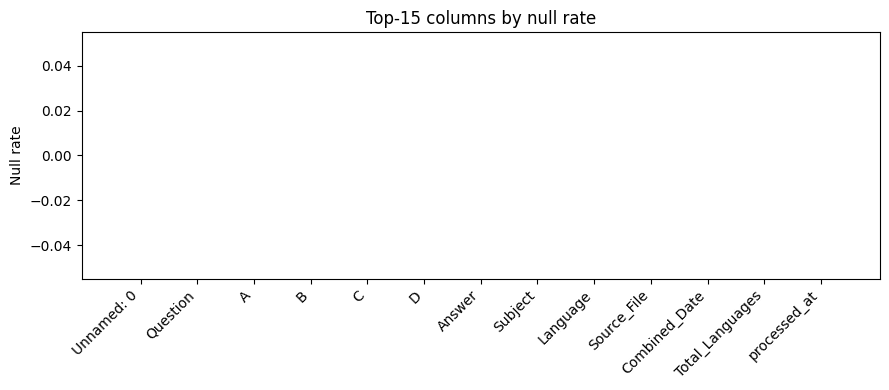

In [10]:
# ---------- Null rates ----------
null_rates = df.isna().mean().sort_values(ascending=False)
plt.figure(figsize=(9,4))
top = null_rates.head(15)
plt.bar(top.index.astype(str), top.values)
plt.title("Top-15 columns by null rate")
plt.ylabel("Null rate")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Insight:-

- No columns are NULL all have values

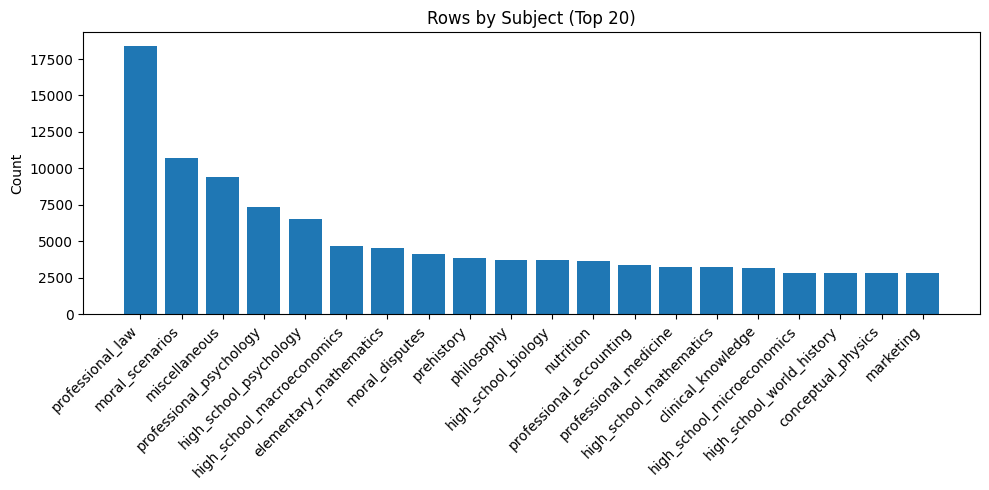

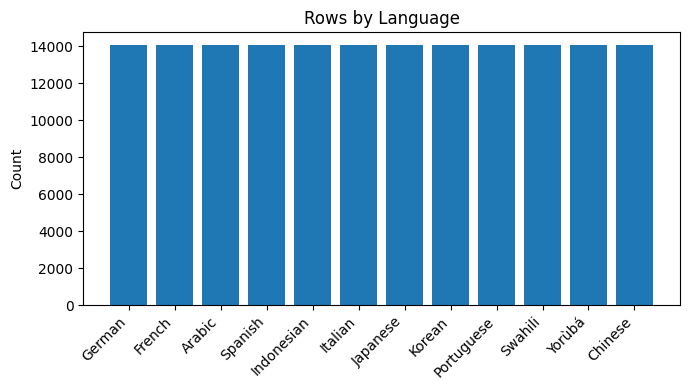

In [12]:
# ---------- Basic distributions ----------
# 1) Subject counts (top 20)
plt.figure(figsize=(10,5))
tc = top_counts(df[COLS["subject"]], k=20)
plt.bar(tc.index, tc.values)
plt.title("Rows by Subject (Top 20)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2) Language counts
plt.figure(figsize=(7,4))
tc = top_counts(df[COLS["language"]], k=20)
plt.bar(tc.index, tc.values)
plt.title("Rows by Language")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



Insights

- The Professional Law subject has the highest number of questions, followed by Moral Scenarios.

- The dataset is balanced across languages, with each language containing an equal number of questions.


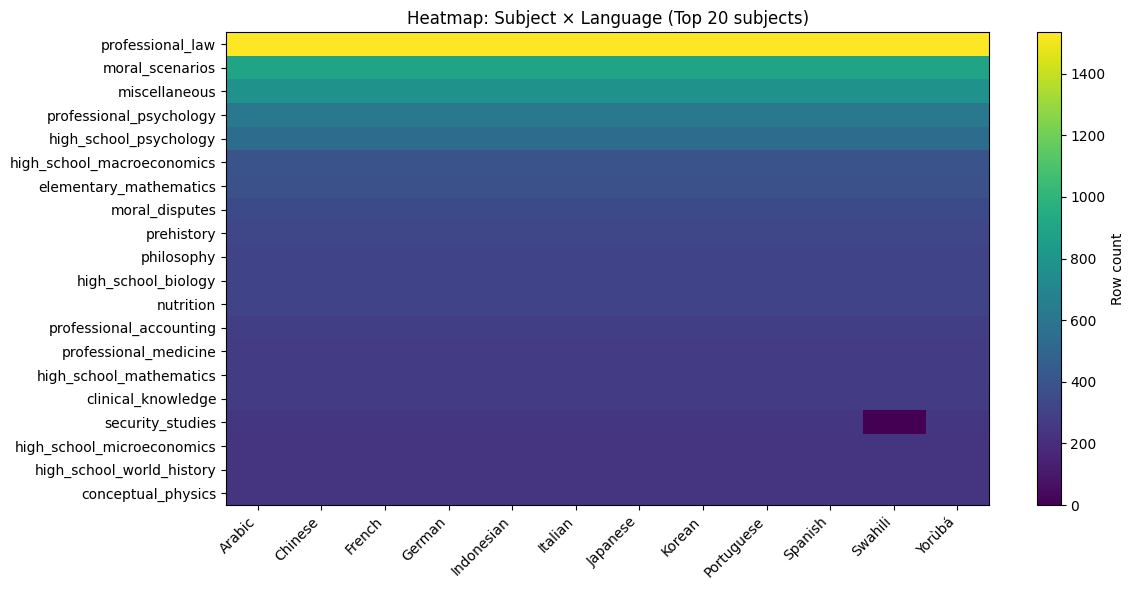

In [13]:

# ---------- Subject × Language heatmap ----------
pivot = (df
         .pivot_table(index=COLS["subject"], columns=COLS["language"],
                      values=COLS["question"], aggfunc="count", fill_value=0))
# keep top subjects/languages to keep heatmap readable
pivot = pivot.sort_values(pivot.columns.tolist(), ascending=False).head(20)
plt.figure(figsize=(12,6))
plt.imshow(pivot.values, aspect="auto")
plt.colorbar(label="Row count")
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45, ha="right")
plt.title("Heatmap: Subject × Language (Top 20 subjects)")
plt.tight_layout()
plt.show()


Insights
- Professional Law has the most questions, followed by Moral Scenarios.

- Most other subjects have moderate and fairly even coverage.

- Languages are balanced, with each subject represented across all languages.

- Some subjects are slightly underrepresented in Swahili,

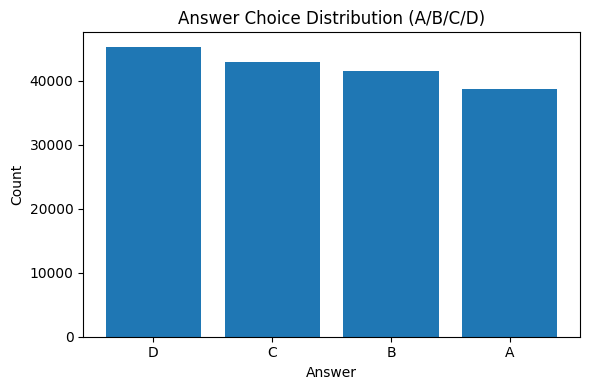

In [14]:
# ---------- Answer choice distribution ----------
plt.figure(figsize=(6,4))
ans_counts = df[COLS["answer"]].astype(str).str.strip().value_counts()
plt.bar(ans_counts.index, ans_counts.values)
plt.title("Answer Choice Distribution (A/B/C/D)")
plt.xlabel("Answer")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Insighs
- Overall Answer Choice Distribution

- D > C > B > A

- D has about 6k more questions than A.

- Spread is fairly balanced but not perfectly equal.

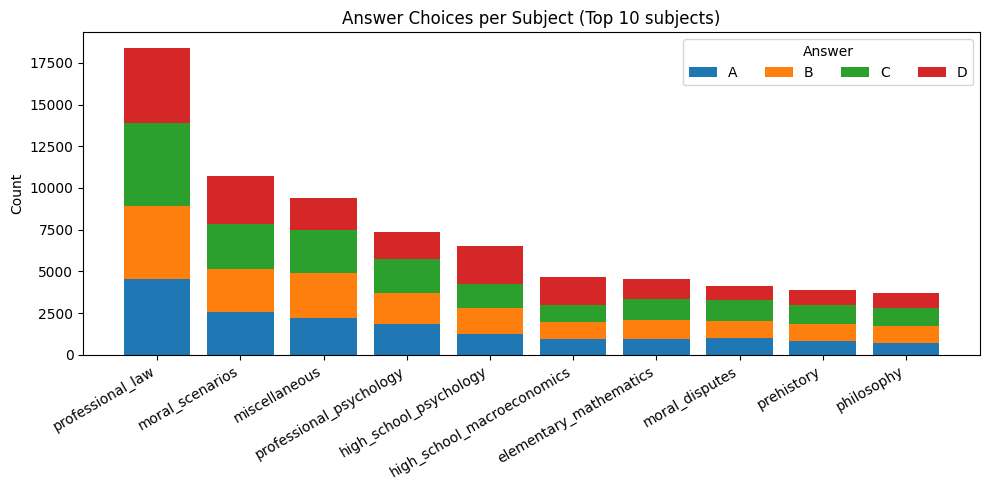

In [15]:
# Stacked by Subject (Top 10)
top_subj = top_counts(df[COLS["subject"]], 10).index.tolist()
sub_df = df[df[COLS["subject"]].isin(top_subj)].copy()
stack = (sub_df
         .pivot_table(index=COLS["subject"], columns=COLS["answer"],
                      values=COLS["question"], aggfunc="count", fill_value=0)
         .reindex(index=top_subj))
stack = stack.reindex(columns=sorted(stack.columns))  # order A..D
bottom = np.zeros(len(stack))
plt.figure(figsize=(10,5))
for col in stack.columns:
    plt.bar(stack.index, stack[col].values, bottom=bottom, label=col)
    bottom = bottom + stack[col].values
plt.title("Answer Choices per Subject (Top 10 subjects)")
plt.xticks(rotation=30, ha="right")
plt.ylabel("Count")
plt.legend(title="Answer", ncols=len(stack.columns))
plt.tight_layout()
plt.show()

Insights
- Professional Law has the largest volume of answers across all choices.

- Moral Scenarios is second but noticeably smaller.

- Other subjects (e.g., Miscellaneous, Psychology) show similar A/B/C/D distribution, just at lower counts.

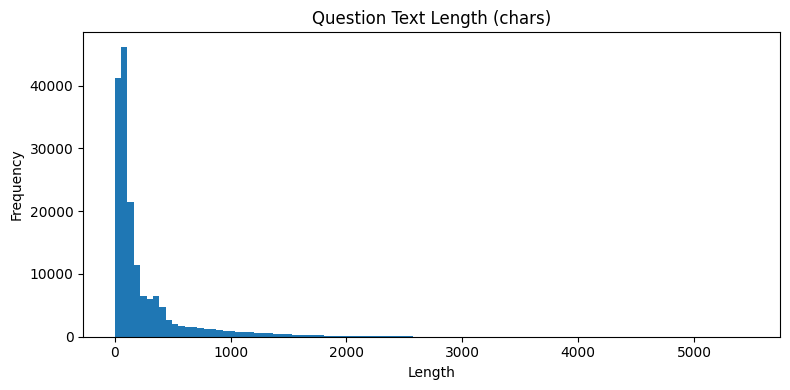

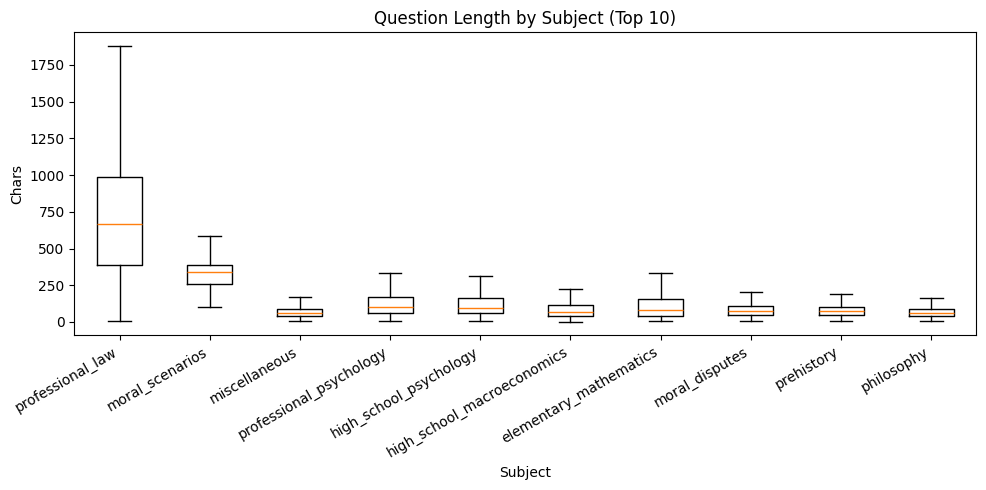

In [20]:
# ---------- Question & Option text lengths ----------
df["question_len"] = text_len(df[COLS["question"]])
for opt in ["A","B","C","D"]:
    df[f"{opt}_len"] = text_len(df[COLS[opt]])

# Question length histogram
plt.figure(figsize=(8,4))
plt.hist(df["question_len"].dropna(), bins=100)
plt.title("Question Text Length (chars)")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Question length by top subjects (boxplot)
qbx = [df.loc[df[COLS["subject"]]==s, "question_len"].dropna().values for s in top_subj]
plt.figure(figsize=(10,5))
plt.boxplot(qbx, showfliers=False)
plt.title("Question Length by Subject (Top 10)")
plt.xlabel("Subject")
plt.ylabel("Chars")
plt.xticks(range(1, len(top_subj)+1), top_subj, rotation=30, ha="right")
plt.tight_layout()
plt.show()


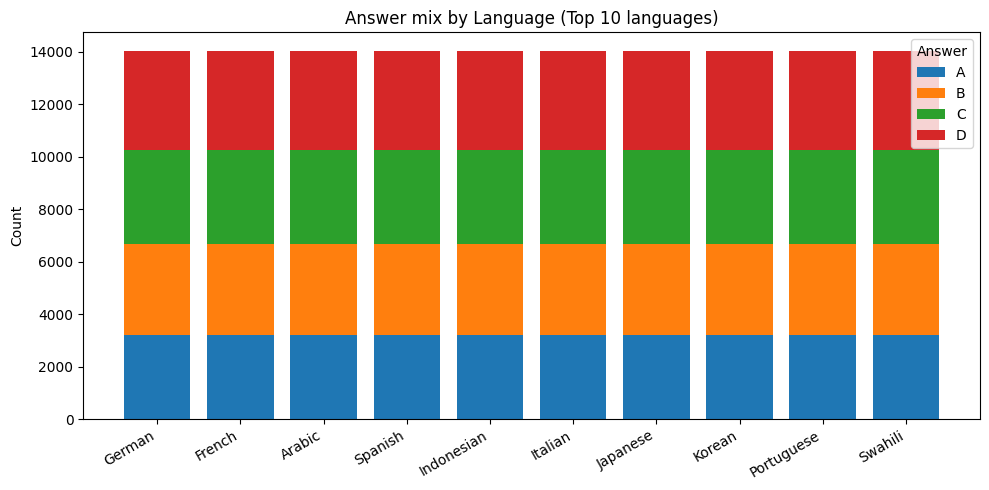


All plots generated.


In [22]:

con = duckdb.connect()
con.register("t", df)
sql = f"""
SELECT {COLS['language']} AS language,
       {COLS['answer']}   AS answer,
       COUNT(*) AS n
FROM t
GROUP BY 1,2
ORDER BY 1,2;
"""
ans_lang = con.execute(sql).df()
if not ans_lang.empty:
    pivot = ans_lang.pivot_table(index="language", columns="answer", values="n", fill_value=0)
    pivot = pivot.loc[top_counts(df[COLS["language"]], 10).index.tolist()]
    bottom = np.zeros(len(pivot))
    plt.figure(figsize=(10,5))
    for col in sorted(pivot.columns):
        plt.bar(pivot.index, pivot[col].values, bottom=bottom, label=col)
        bottom += pivot[col].values
    plt.title("Answer mix by Language (Top 10 languages)")
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("Count")
    plt.legend(title="Answer")
    plt.tight_layout()
    plt.show()

print("\nAll plots generated.")

Insights
- The pattern (A ≈ B ≈ C ≈ D order) is almost identical across all languages.

- Very minor differences exist, but no language strongly favors one answer choice.

- Confirms that languages are balanced in answer distribution.